# SciBert - multiclass classification - dataset_v6


Kód byl adaptován na základě:
https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multiclass_classification.ipynb#scrollTo=ZM5eVl6BQ1yY
https://github.com/bhavyajeet/3c-citation_text_classification/blob/master/task1/first/first.py
https://www.kaggle.com/code/dijiswiki/text-classification-with-scibert

In [ ]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from torch import cuda
import sys
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel

In [ ]:
LMTokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
LMModel = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('publications_final.csv', sep=';', encoding="utf-8")

In [ ]:
column_delete = ['Vědní obor','year','AIS','IF','FORD_WOS','category','Seznam tvůrců','Počet tvůrců celkem','Název organizace']
df = df.drop(column_delete, axis=1)
df['final_grade'] = df['final_grade'].astype(int)
df.head(3)

,title,abstract,keywords,journal,final_grade
0,A transparent insulation facade enhanced with ...,Solar thermal façade concepts for building int...,"Solar wall, Solar façade, Transparent insulati...",ENERGY AND BUILDINGS,2
1,A LHCB9-dependent photosystem I megacomplex in...,Photosystem I of the moss Physcomitrella paten...,electron microscopy:Physcomitrella patens:mega...,Nature Plants,2
2,A link between knowledge sharing and managers’...,Purpose – The purpose of this paper is to exam...,"Knowledge sharing, Supervisor, Knowledge-orien...",Leadership and Organization Development Journal,3


In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=123)

In [ ]:
# Resetování indexů
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

In [ ]:
test_dataset.count()

title          803
abstract       803
keywords       803
journal        803
final_grade    803
dtype: int64

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
LEARNING_RATE = 1e-5
drop_out = 0.2
EPOCHS = 4
tokenizer = LMTokenizer

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        title_ids = inputs['input_ids']
        title_mask = inputs['attention_mask']


        keywords = str(self.data.keywords[index])
        keywords = " ".join(keywords.split())
        inputs = self.tokenizer.encode_plus(
            keywords,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        keywords_ids = inputs['input_ids']
        keywords_mask = inputs['attention_mask']


        abstract = str(self.data.abstract[index])
        abstract = " ".join(abstract.split())
        inputs = self.tokenizer.encode_plus(
            abstract,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        abstract_ids = inputs['input_ids']
        abstract_mask = inputs['attention_mask']


        journal = str(self.data.journal[index])
        journal = " ".join(journal.split())
        inputs = self.tokenizer.encode_plus(
            journal,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        journal_ids = inputs['input_ids']
        journal_mask = inputs['attention_mask']


        return {
            'title_ids': torch.tensor(title_ids, dtype=torch.long),
            'title_mask': torch.tensor(title_mask, dtype=torch.long),

            'abstract_ids': torch.tensor(abstract_ids, dtype=torch.long),
            'abstract_mask': torch.tensor(abstract_mask, dtype=torch.long),

            'keywords_ids': torch.tensor(keywords_ids, dtype=torch.long),
            'keywords_mask': torch.tensor(keywords_mask, dtype=torch.long),

            'journal_ids': torch.tensor(journal_ids, dtype=torch.long),
            'journal_mask': torch.tensor(journal_mask, dtype=torch.long),

            'targets': torch.tensor(self.data.final_grade[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len


In [ ]:
training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class LMClass(torch.nn.Module):
    def __init__(self):
        super(LMClass, self).__init__()
        self.l1 = LMModel
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(drop_out)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, data):

        input_ids = data['abstract_ids'].to(device, dtype = torch.long)
        attention_mask = data['abstract_mask'].to(device, dtype = torch.long)

        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state1 = output_1[0]

        pooler = hidden_state1[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = LMClass()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(data)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}\n')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}\n")
    print(f"Training Accuracy Epoch: {epoch_accu}\n")
    print("\n")
    return

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The Total Accuracy for Epoch 0: 43.48503740648379

Training Loss Epoch: 1.306276422827991

Training Accuracy Epoch: 43.48503740648379



The Total Accuracy for Epoch 1: 48.12967581047381

Training Loss Epoch: 1.2069866766977073

Training Accuracy Epoch: 48.12967581047381



The Total Accuracy for Epoch 2: 54.083541147132166

Training Loss Epoch: 1.110709693004836

Training Accuracy Epoch: 54.083541147132166



The Total Accuracy for Epoch 3: 63.21695760598504

Training Loss Epoch: 0.9447220767018807

Training Accuracy Epoch: 63.21695760598504





Cost Matrix:
[[ 0  1  4  9 16 25]
 [ 1  0  1  4  9 16]
 [ 4  1  0  1  4  9]
 [ 9  4  1  0  1  4]
 [16  9  4  1  0  1]
 [25 16  9  4  1  0]]


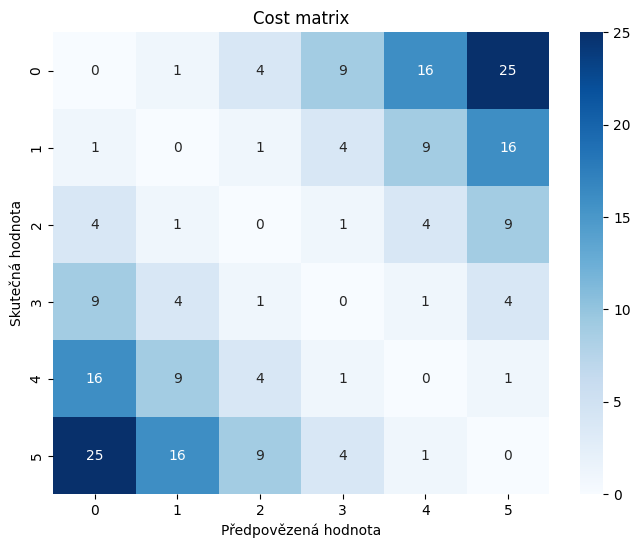

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def mse_cost_matrix(M):
    cost_matrix = np.zeros((M, M), dtype=int)

    for i in range(M):
        for j in range(M):
            if i != j:
                squared_deviation = (j - i)**2
                cost_matrix[i, j] =  squared_deviation

    return cost_matrix


class_sizes  = [train_dataset['final_grade'].value_counts()[0],train_dataset['final_grade'].value_counts()[1],train_dataset['final_grade'].value_counts()[2],train_dataset['final_grade'].value_counts()[3],train_dataset['final_grade'].value_counts()[4],train_dataset['final_grade'].value_counts()[5]]
M = len(class_sizes)

cost_matrix_mse = mse_cost_matrix(M)

print("Cost Matrix:")
print(cost_matrix_mse)

plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix_mse, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Předpovězená hodnota')
plt.ylabel('Skutečná hodnota')
plt.title('Cost matrix')
plt.show()



Cost Matrix:
[[0 1 2 3 4 5]
 [1 0 1 2 3 4]
 [2 1 0 1 2 3]
 [3 2 1 0 1 2]
 [4 3 2 1 0 1]
 [5 4 3 2 1 0]]


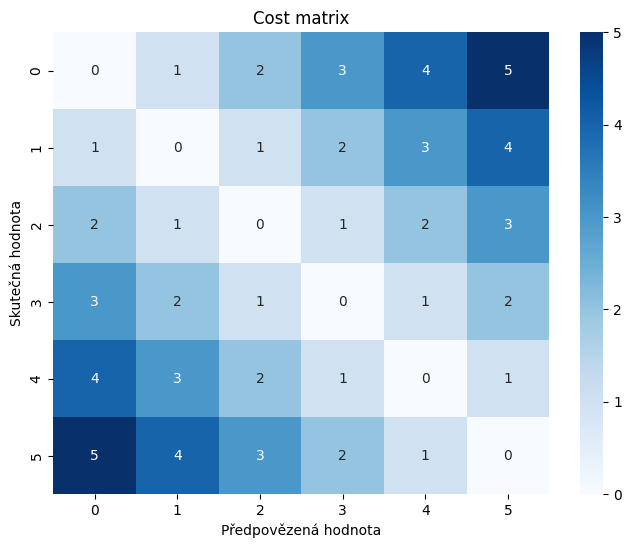

In [ ]:
def mae_cost_matrix(M):
    cost_matrix = np.zeros((M, M), dtype=int)

    for i in range(M):
        for j in range(M):
            if i != j:
                absolute_deviation = np.abs(j - i)
                cost_matrix[i, j] =  absolute_deviation

    return cost_matrix

# class_sizes = train_dataset.nunique()
class_sizes = class_sizes = [train_dataset['final_grade'].value_counts()[0],train_dataset['final_grade'].value_counts()[1],train_dataset['final_grade'].value_counts()[2],train_dataset['final_grade'].value_counts()[3],train_dataset['final_grade'].value_counts()[4],train_dataset['final_grade'].value_counts()[5]]
M = len(class_sizes)

cost_matrix_mae = mae_cost_matrix(M)

print("Cost Matrix:")
print(cost_matrix_mae)

plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix_mae, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Předpovězená hodnota')
plt.ylabel('Skutečná hodnota')
plt.title('Cost matrix')
plt.show()

In [ ]:
def evaluate(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; tr_loss = 0
    nb_tr_steps =0
    nb_tr_examples =0
    pred = []
    act = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(data).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)
            pred += big_idx.tolist()
            act += targets.tolist()
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

    print('Classification Report:')
    print(classification_report(act, pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(act, pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt="d")
    ax.set_xlabel('Předpovězená hodnota')
    ax.set_ylabel('Skutečná hodnota')

    n = test_dataset['final_grade'].count()
    print("pocet radku - testovaci dataset: " + str(n))
    mae = np.multiply(cm, cost_matrix_mae).sum() / n
    mae = round(mae, 3)


    mse = np.multiply(cm, cost_matrix_mse).sum() / n
    mse = round(mse, 3)

    print("MSE: " + str(mse))
    print("MAE: " + str(mae))


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.37      0.38      0.38       134
           2       0.45      0.59      0.51       322
           3       0.48      0.43      0.45       264
           4       0.67      0.04      0.07        56
           5       0.00      0.00      0.00        10

    accuracy                           0.45       803
   macro avg       0.33      0.24      0.23       803
weighted avg       0.45      0.45      0.42       803



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pocet radku - testovaci dataset: 803
MSE: 0.851
MAE: 0.644


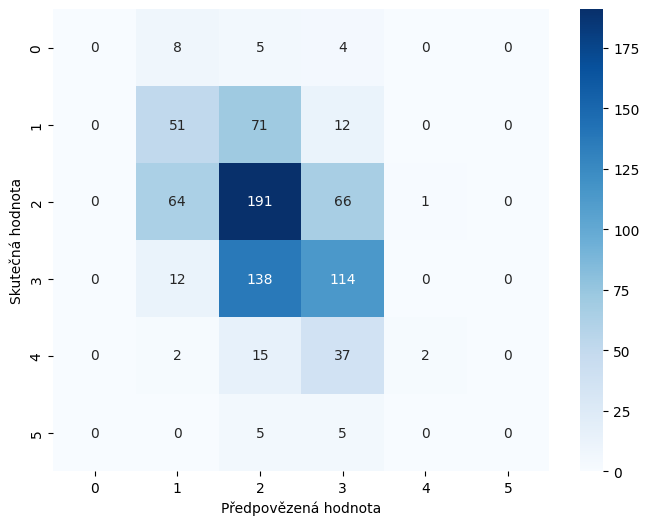

In [ ]:
evaluate(model,testing_loader)